<a href="https://colab.research.google.com/github/Nayoung-young/prj-ecommerce-ltv/blob/main/e_commerce_LTV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# _0.라이브러리 임포트

In [1]:
!pip install plotly
!pip install Lifetimes
!pip install nb_black

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
import pandas as pd # python에서의 엑셀과 같은 역할
import numpy as np # 계산을 편하게 해 주는 라이브러리
import matplotlib as mpl
import matplotlib.pyplot as plt # 시각화
import seaborn as sns # 시각화
import math

import matplotlib.ticker as ticker # 시각화
import matplotlib.dates as mdates # 시각화

import datetime as dt

import warnings

warnings.filterwarnings('ignore')
sns.set_theme(style='white')

# from other 
import matplotlib.colors as mcolors
from sklearn.metrics import (silhouette_score,
                             calinski_harabasz_score,
                             davies_bouldin_score)
%matplotlib inline
sns.set_style('whitegrid')
palette = 'Set2'

# sns.set(font_scale=2)

# _1. 데이터 불러오기 

In [3]:
%%time
df = pd.read_csv('/content/e-commerce_LTV.csv', encoding= 'unicode_escape')
df_base = df.copy()

CPU times: user 826 ms, sys: 167 ms, total: 993 ms
Wall time: 1.01 s


In [4]:
df_base.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [5]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
len(df_base['InvoiceNo'].unique().tolist()) # InvoiceNo가 primary key인가? -> Nope 

25900

In [7]:
print(min(df_base['Quantity'].tolist()))
print(max(df_base['Quantity'].tolist())) # Quantity 범위 확인 

-80995
80995


In [8]:
quantity = df_base['Quantity'].tolist() 

print(len(list(filter(lambda x: x < 0, quantity)))) # quantity < 0 인 경우 
print(len(list(filter(lambda x: x > 0, quantity)))) # quantity > 0 인 경우 

10624
531285


In [9]:
sum(df_base['Quantity'].dropna())

5176450

In [10]:
# df_base['Country'].unique().tolist() # Country 고유값

In [11]:
# df_base.groupby(['Country']).agg(country_cnt = ('Country', 'count')).reset_index().sort_values(by = 'country_cnt', ascending =False)

#_1. 데이터 전처리

In [12]:
df_base.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

## 1.1 컬럼명 바꾸기 

In [13]:
# 컬럼 이름 snake case 로 rename 
%%time
df_base.rename(columns = {'InvoiceNo':'invoice_no', 
                        'StockCode':'stock_code', 
                        'Quantity': 'quantity',
                        'Description':'description',
                        'InvoiceDate': 'invoice_date',
                        'UnitPrice': 'unit_price', 
                        'CustomerID': 'customer_id', 
                        'Country':'country'}, inplace = True)

CPU times: user 920 µs, sys: 0 ns, total: 920 µs
Wall time: 930 µs


In [14]:
LTV_columns = ['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'customer_id']
df_LTV = df_base[LTV_columns]

In [15]:
df_LTV.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   invoice_no    541909 non-null  object 
 1   stock_code    541909 non-null  object 
 2   quantity      541909 non-null  int64  
 3   invoice_date  541909 non-null  object 
 4   unit_price    541909 non-null  float64
 5   customer_id   406829 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 24.8+ MB


## 1.2 결측값 처리 
- customer_id: 
  - 결측값 = 비회원으로 추정
  - 추후 LTV 계산에서 활용하지는 않을 것이지만 fillna(0)
  - object로 타입 변환 

In [151]:
df_LTV_01 = df_LTV.copy()

In [152]:
## customer_id type 변환해도될지 체크 
%%time 
list(filter(lambda x: str(x)[-1] != '0', df_LTV_01['customer_id'].unique().tolist()))

CPU times: user 13.2 ms, sys: 0 ns, total: 13.2 ms
Wall time: 13.8 ms


[nan]

In [153]:
df_LTV_01['customer_id'].isna().sum() # customer_id 결측값 확인 

135080

In [154]:
df_LTV_01.sample(5)

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id
422412,573083,23541,3,10/27/2011 14:22,8.25,13735.0
413815,572323,23530,6,10/24/2011 9:46,4.95,14312.0
4737,536799,22746,2,12/2/2010 16:00,2.10,17228.0
478299,577078,22138,1,11/17/2011 15:17,10.79,NaN
460863,575930,22386,1,11/11/2011 17:58,4.13,NaN


In [155]:
df_LTV_01[df_LTV_01['invoice_no'] == '536865' ] # 비회원으로 추정, LTV 계산에서 활용 불가 

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id
5546,536865,10002,5,12/3/2010 11:28,1.66,NaN
5547,536865,15056bl,2,12/3/2010 11:28,12.72,NaN
5548,536865,18098c,7,12/3/2010 11:28,5.06,NaN
5549,536865,20615,1,12/3/2010 11:28,4.21,NaN
5550,536865,20655,1,12/3/2010 11:28,2.51,NaN
...,...,...,...,...,...,...
5681,536865,85099B,1,12/3/2010 11:28,4.21,NaN
5682,536865,85152,1,12/3/2010 11:28,4.21,NaN
5683,536865,85176,1,12/3/2010 11:28,1.66,NaN
5684,536865,M,1,12/3/2010 11:28,2.55,NaN


In [156]:
df_LTV_01['customer_id'] = df_LTV_01['customer_id'].fillna(0)

In [157]:
df_LTV_01['customer_id'].isna().sum() # customer_id

0

In [158]:
%%time 
df_LTV_01 = df_LTV_01.astype({'customer_id' : 'int'}) # float 였으므로 .0 없애기 위해 먼저 int로 변환 
df_LTV_01 = df_LTV_01.astype({'customer_id' : 'str'})

CPU times: user 227 ms, sys: 32 ms, total: 259 ms
Wall time: 264 ms


In [159]:
## invoice_no, stock_code도 type str로 변경 
df_LTV_01 = df_LTV_01.astype({'invoice_no' : 'str'})
df_LTV_01 = df_LTV_01.astype({'stock_code' : 'str'})

In [160]:
df_LTV_01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   invoice_no    541909 non-null  object 
 1   stock_code    541909 non-null  object 
 2   quantity      541909 non-null  int64  
 3   invoice_date  541909 non-null  object 
 4   unit_price    541909 non-null  float64
 5   customer_id   541909 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 24.8+ MB


## 1.3 invoice_date
- 현재 type: object -> datetime으로 변경 

In [161]:
df_LTV_01.sample(10)

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id
357856,568134,23029,2,9/23/2011 17:02,3.29,0
85160,543466,22087,6,2/8/2011 14:34,2.95,16713
520153,580272,20914,3,12/2/2011 12:52,2.95,15547
63189,541524,48185,2,1/19/2011 10:49,7.95,17091
55564,540995,22279,3,1/13/2011 9:30,0.83,0
441865,574657,23247,2,11/6/2011 11:43,2.89,13772
82100,543188,22077,12,2/4/2011 11:45,1.65,12567
331970,566049,21741,6,9/8/2011 14:28,2.95,15730
386983,570258,21329,1,10/10/2011 9:56,3.29,0
83873,543355,21670,2,2/7/2011 13:50,1.25,16033


In [162]:
df_LTV_01['invoice_datetime'] = pd.to_datetime(df_LTV_01['invoice_date'], format = '%m/%d/%Y %H:%M')

df_LTV_01['invoice_date'] = df_LTV_01['invoice_datetime'].dt.date

In [163]:
df_LTV_01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   invoice_no        541909 non-null  object        
 1   stock_code        541909 non-null  object        
 2   quantity          541909 non-null  int64         
 3   invoice_date      541909 non-null  object        
 4   unit_price        541909 non-null  float64       
 5   customer_id       541909 non-null  object        
 6   invoice_datetime  541909 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 28.9+ MB


In [164]:
# date관련 데이터 추가하기: 월 정보
# df_LTV_01['invoice_year'] = df_LTV_01['invoice_datetime'].dt.year
# df_LTV_01['invoice_month'] = df_LTV_01['invoice_datetime'].dt.month
# df_LTV_01['invoice_day'] = df_LTV_01['invoice_datetime'].dt.day

# df_LTV_01 = df_LTV_01.astype({'invoice_year' : 'int'}) 
# df_LTV_01 = df_LTV_01.astype({'invoice_month' : 'int'}) 
# df_LTV_01 = df_LTV_01.astype({'invoice_day' : 'int'}) 

## 최종 모델에서 활용하지 않았음 

df_LTV_01.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,invoice_datetime
0,536365,85123A,6,2010-12-01,2.55,17850,2010-12-01 08:26:00
1,536365,71053,6,2010-12-01,3.39,17850,2010-12-01 08:26:00
2,536365,84406B,8,2010-12-01,2.75,17850,2010-12-01 08:26:00
3,536365,84029G,6,2010-12-01,3.39,17850,2010-12-01 08:26:00
4,536365,84029E,6,2010-12-01,3.39,17850,2010-12-01 08:26:00


#_2. 파악을 위한 시각화 

**[ 변수 정보 ]**
*   InvoiceNo: Invoice number that consists 6 digits. If this code starts with letter 'c', it indicates a cancellation.
*   StockCode: Product code that consists 5 digits.
*   Description: Product name.
*   Quantity: The quantities of each product per transaction.
*   InvoiceDate: Represents the day and time when each transaction was generated.
*   CustomerID: Customer number that consists 5 digits. Each customer has a unique customer ID.
*   Country: Name of the country where each customer resides.


In [165]:
# 시각화 라이브러리 
import plotly.graph_objs as go
from plotly.offline import iplot

In [166]:
world_map = df_base[['customer_id', 'invoice_no', 'country']
              ].groupby(['customer_id', 'invoice_no', 'country']
                       ).count().reset_index()

countries = world_map['country'].value_counts()

data = dict(type='choropleth',
            locations = countries.index,
            locationmode = 'country names',
            z = countries,
            text = countries.index,
            colorbar = {'title':'Orders'},
            colorscale='Viridis',
            reversescale = False)

layout = dict(title={'text': "Number of Orders by Countries",
                     'y':0.9,
                     'x':0.5,
                     'xanchor': 'center',
                     'yanchor': 'top'},
              geo = dict(resolution = 50,
                         showocean = True,
                         oceancolor = "LightBlue",
                         showland = True,
                         landcolor = "whitesmoke",
                         showframe = True),
             template = 'plotly_white',
             height = 600,
             width = 1000)

choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate = False)

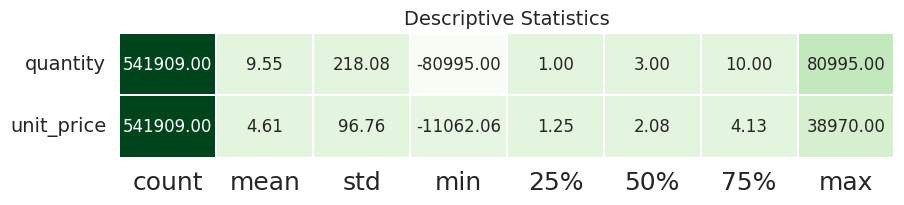

In [167]:
def desc_stats(dataframe):
    desc_df = pd.DataFrame(index= dataframe.columns, 
                           columns= dataframe.describe().T.columns,
                           data= dataframe.describe().T)
    
    f,ax = plt.subplots(figsize=(10,
                                 desc_df.shape[0] * 0.81))
    sns.heatmap(desc_df,
                annot = True,
                cmap = "Greens",
                fmt = '.2f',
                ax = ax,
                linecolor = 'white',
                linewidths = 1.1,
                cbar = False,
                annot_kws = {"size": 12})
    plt.xticks(size = 18)
    plt.yticks(size = 14,
               rotation = 0)
    plt.title("Descriptive Statistics", size = 14)
    plt.show()
    
desc_stats(df_LTV_01.select_dtypes(include = [float, int]))

* 취소된 주문내역 때문에 quantity < 0인 row 존재 
* total_price = quantity * unit_price로 구할 예정 

## 2.1 unit_price, quantity에 대한 확인 
- quantity < 0 인 부분 확인  
- stock_code가 같은데도 unit_price가 다른 경우에 대한 확인 

In [168]:
df_LTV_01[df_LTV_01['quantity'] < 0].sample(5)

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,invoice_datetime
369945,C569112,22362,-3,2011-09-30,2.95,17405,2011-09-30 12:47:00
253971,C559253,21669,-1,2011-07-07,1.25,12472,2011-07-07 11:44:00
140754,C548460,22960,-6,2011-03-31,4.25,16801,2011-03-31 11:58:00
337774,C566467,20723,-20,2011-09-12,0.85,14688,2011-09-12 18:04:00
106054,C545307,22414,-1,2011-03-01,7.95,17027,2011-03-01 13:05:00


In [169]:
# pd.set_option('display.max_columns', None) ## 모든 열을 출력한다.
# pd.set_option('display.max_rows', None) ## 모든 열을 출력한다.

In [170]:
# df_LTV_01[df_LTV_01['customer_id'] == 12471] # quantity < 0인 행이 있는 customer 확인 

- invoice_no 가장 앞에 C가 있으면 취소한 내역, 취소했을 시 quantity < 0 
- but, C 뒤 번호로 어떤 내역을 취소한 건지 확인 불가 (해당하는 invoice_no 없음) -> 주문 전체 취소라면 그 주문번호 앞에 C가 붙어있지만, 아니라면 아예 새로운 주문번호 + C 를 부여하는 듯? 

구매 내역만 필요하긴 하지만, 
- 구매 건수: 환불 건수 제외하고 nunique 
- 총 주문금액: 주문 금액 - 환불금액 의 sum이어야 함 

quantity < 0 인 경우를 확인해보자. 

In [171]:
df_LTV_01[df_LTV_01['unit_price'] == 0].sample(5) # unit_price == 0인 경우 확인 

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,invoice_datetime
432118,573816,20898,-10,2011-11-01,0.0,0,2011-11-01 11:32:00
268300,560400,21069,6,2011-07-18,0.0,0,2011-07-18 14:19:00
7196,537004,21814,-30,2010-12-03,0.0,0,2010-12-03 15:34:00
75229,542553,21805,-1,2011-01-28,0.0,0,2011-01-28 14:49:00
314747,564651,22955,144,2011-08-26,0.0,14646,2011-08-26 14:19:00


In [172]:
df_LTV_01[df_LTV_01['unit_price'] < 0].head() # unit_price < 0인 경우 확인 

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,invoice_datetime
299983,A563186,B,1,2011-08-12,-11062.06,0,2011-08-12 14:51:00
299984,A563187,B,1,2011-08-12,-11062.06,0,2011-08-12 14:52:00


In [173]:
df_base[df_base['stock_code'] == 'B'] # unit_price < 0 인 상품 확인 

# stock_code = 'B'인 상품: 	Adjust bad debt	 <- 즉, 구매 내역은 아님 
# 어차피 customer_id = NaN이기 때문에 추후 드랍할 예정 

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
299982,A563185,B,Adjust bad debt,1,8/12/2011 14:50,11062.06,NaN,United Kingdom
299983,A563186,B,Adjust bad debt,1,8/12/2011 14:51,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,8/12/2011 14:52,-11062.06,NaN,United Kingdom


In [174]:
print((df_LTV_01[df_LTV_01['unit_price'] == 0].shape)) 
print((df_LTV_01[df_LTV_01['customer_id'] == 0].shape))

print((df_LTV_01[(df_LTV_01['customer_id'] == 0) & (df_LTV_01['unit_price'] == 0)].shape))

(2515, 7)
(0, 7)
(0, 7)


In [175]:
# df_LTV_01[ (df_LTV_01['unit_price'] == 0) & (df_LTV_01['customer_id'] != 0) ]

In [176]:
df_base[df_base['stock_code'] == '22034'] # unit_price == 0 인 상품 확인 

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
8828,537153,22034,ROBIN CHRISTMAS CARD,3,12/5/2010 13:03,0.42,16718.0,United Kingdom
19996,537999,22034,NaN,-223,12/9/2010 11:44,0.00,NaN,United Kingdom
35347,539436,22034,ROBIN CHRISTMAS CARD,5,12/17/2010 14:49,0.42,NaN,United Kingdom
44297,C540164,22034,ROBIN CHRISTMAS CARD,-12,1/5/2011 12:02,0.42,14911.0,EIRE
243332,558445,22034,NaN,-18,6/29/2011 13:39,0.00,NaN,United Kingdom
270602,560578,22034,NaN,12,7/19/2011 15:12,0.00,NaN,United Kingdom
469110,576580,22034,NaN,-5,11/15/2011 14:15,0.00,NaN,United Kingdom
490649,578065,22034,ROBIN CHRISTMAS CARD,1,11/22/2011 15:41,0.83,NaN,United Kingdom
501878,578833,22034,ROBIN CHRISTMAS CARD,1,11/25/2011 15:23,0.83,NaN,United Kingdom


- unit_price = 0인 이유에 대해 확정짓기 어려움 

    - 같은 stock_code인데도 unit_price = 0 인 경우 존재 
    -  unit_price = 0 인 경우 중 customer_id이 NaN이었던 경우가 대부분이긴 했으나, 이유를 추측하기 어려움 


**추측**
1.   단기성 이벤트로 해당 상품을 무료로 증정한 적이 있었다 
2.   프로모션이 진행됨에 따라 같은 stock_code여도 unit_price가 다를 수 있다 

## 2.2 unit_price, quantity에 대한 추가 전처리 


In [177]:
# df_LTV_01['total_price'] = df_LTV_01['quantity'] * df_LTV_01['unit_price']

In [178]:
# df_LTV_01.groupby('customer_id').agg({"total_price": "sum"})

In [179]:
## rollback을 위해 copy 
df_LTV_02 = df_LTV_01.copy()
# df_LTV_02 = df_LTV_02[df_LTV_02['quantity'] > 0]

In [180]:
# ## total_price = quantity * unit_price 열 추가 
df_LTV_02['total_price'] = df_LTV_02['quantity'] * df_LTV_02['unit_price']

In [181]:
# ## total_price = quantity * unit_price 열 추가 
# df_LTV_02['total_price'] = df_LTV_02['quantity'] * df_LTV_02['unit_price']

In [182]:
df_LTV_01.shape

(541909, 7)

In [183]:
df_LTV_02.shape

(541909, 8)

In [184]:
## customer_id == '0'인 경우 drop 
df_LTV_02 = df_LTV_02[ df_LTV_02['customer_id'] != '0']

In [185]:
df_LTV_02.shape

(406829, 8)

In [186]:
df_LTV_02.info() # 최종 LTV 계산에 활용할 데이터 형태 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   invoice_no        406829 non-null  object        
 1   stock_code        406829 non-null  object        
 2   quantity          406829 non-null  int64         
 3   invoice_date      406829 non-null  object        
 4   unit_price        406829 non-null  float64       
 5   customer_id       406829 non-null  object        
 6   invoice_datetime  406829 non-null  datetime64[ns]
 7   total_price       406829 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


In [187]:
df_LTV_02.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,invoice_datetime,total_price
0,536365,85123A,6,2010-12-01,2.55,17850,2010-12-01 08:26:00,15.30
1,536365,71053,6,2010-12-01,3.39,17850,2010-12-01 08:26:00,20.34
2,536365,84406B,8,2010-12-01,2.75,17850,2010-12-01 08:26:00,22.00
3,536365,84029G,6,2010-12-01,3.39,17850,2010-12-01 08:26:00,20.34
4,536365,84029E,6,2010-12-01,3.39,17850,2010-12-01 08:26:00,20.34


#_3. Life Time Value (고객 생애가치) 계산 

In [188]:
max(df_LTV_01['invoice_date'])

datetime.date(2011, 12, 9)

In [189]:
today_date = dt.datetime(2011, 12, 10)

## 3.1 RFM metrics 

**RFM Metrics**
- recency: affects retention, a measure of engagement
- frequency: 구매 빈도 
- monetary: affects a customer's lifetime value 

RFM scoring을 통해 고객을 segmentation할 수도 있음 

In [190]:
df_LTV_02[df_LTV_02['customer_id'] == '12346']

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,invoice_datetime,total_price
61619,541431,23166,74215,2011-01-18,1.04,12346,2011-01-18 10:01:00,77183.6
61624,C541433,23166,-74215,2011-01-18,1.04,12346,2011-01-18 10:17:00,-77183.6


In [203]:
# df_LTV_02[df_LTV_02['customer_id'] == '12348']

In [282]:
%%time 
ltv_df = df_LTV_02.groupby("customer_id").agg(
    {
        "invoice_datetime": [
            lambda x: (x.max() - x.min()).days,
            lambda x: (today_date - x.min()).days,
        ],
        "total_price": "sum",
    }
)

# invoice_df = df_LTV_02[ df_LTV_02['quantity'] > 0 ].groupby("customer_id").agg( { "invoice_no": "nunique" })
invoice_df = df_LTV_02[ df_LTV_02['quantity'] > 0 ].groupby("customer_id").agg( { "invoice_date": "nunique" })


ltv_df.columns = ltv_df.columns.droplevel(0)

invoice_df.head()

ltv_df = pd.merge(ltv_df, invoice_df, left_index=True, right_index=True)
ltv_df.columns = ["recency", "T", "monetary", "frequency"]

ltv_df.head()

CPU times: user 1.51 s, sys: 9.35 ms, total: 1.52 s
Wall time: 1.53 s


,recency,T,monetary,frequency
customer_id,,,,
12346,0,325,0.00,1
12347,365,367,4310.00,7
12348,282,358,1797.24,4
12349,0,18,1757.55,1
12350,0,310,334.40,1


In [283]:
ltv_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4339 entries, 12346 to 18287
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   recency    4339 non-null   int64  
 1   T          4339 non-null   int64  
 2   monetary   4339 non-null   float64
 3   frequency  4339 non-null   int64  
dtypes: float64(1), int64(3)
memory usage: 169.5+ KB


In [284]:
%%time 
# Regency & Tenure (unit: week)
ltv_df["recency"] = ltv_df["recency"] / 7
ltv_df["T"] = ltv_df["T"] / 7

# Frequency (drop if frequency == 0)
# ltv_df["frequency"] = ltv_df["frequency"] / 7
ltv_df = ltv_df[ltv_df["frequency"] > 1]

# Average Order Value  
ltv_df["monetary"] = ltv_df["monetary"] / ltv_df["frequency"]


CPU times: user 5.18 ms, sys: 0 ns, total: 5.18 ms
Wall time: 5.95 ms


In [285]:
ltv_df.head()

# recency = 가장 최근 구매와 그 이전 구매와의 차이 (주)
# T = 가입 이후 시간 (주)
# frequency = 구매 일수 (일)
# monetary = 구매 일수 별 평균 구매금액 (원)

,recency,T,monetary,frequency
customer_id,,,,
12347,52.142857,52.428571,615.714286,7
12348,40.285714,51.142857,449.310000,4
12352,37.142857,42.285714,220.772857,7
12356,43.142857,46.428571,937.143333,3
12358,21.285714,21.428571,584.030000,2


## 3.2 BG/NBD 
- BG(Beta Geometric)/NBD(Negative Binomial Distribution)
-  assume that the number of transactions made by each customer follows a Poisson process with a heterogeneity in transaction rates across customers following a gamma distribution

by using `BetaGeoFitter` and `lifetimes` packages.


- LTV 계산 시 outlier를 사전에 제거했어야 하나? 
- 이 글 다시 보기: https://www.analyticsvidhya.com/blog/2020/10/a-definitive-guide-for-predicting-customer-lifetime-value-clv/ 
  - 아무래도 환불한 그 금액을 합산에 고려했어야 

In [286]:
from lifetimes import BetaGeoFitter, GammaGammaFitter

In [305]:
BGF = BetaGeoFitter(penalizer_coef=0.001)  # avoid overfitting
## In typical applications, penalizers on the order of 0.001 to 0.1 are effective

BGF.fit(ltv_df["frequency"], ltv_df["recency"], ltv_df["T"])

<lifetimes.BetaGeoFitter: fitted with 2790 subjects, a: 0.07, alpha: 16.51, b: 2.17, r: 2.67>

In [306]:
BGF.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,2.672134,0.096533,2.482929,2.861339
alpha,16.513272,0.666580,15.206775,17.819770
a,0.070304,0.010385,0.049950,0.090658
b,2.170629,0.239412,1.701381,2.639877


## 3.3 Visualization 


In [307]:
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix

<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

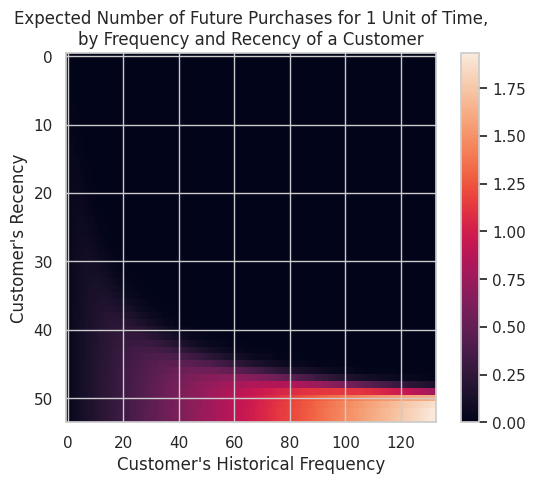

In [308]:
plot_frequency_recency_matrix(BGF)

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

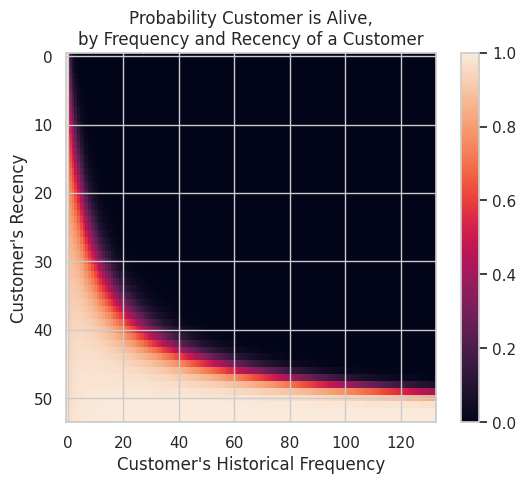

In [309]:
plot_probability_alive_matrix(BGF)

## Expectation 
- Top 10 Expected Number of Transaction (1 Week) 
- Top 10 Expected Number of Transaction (1 Month) 

In [310]:
## - Top 10 Expected Number of Transaction (1 Week)  
BGF.conditional_expected_number_of_purchases_up_to_time(
    1, ltv_df["frequency"], ltv_df["recency"], ltv_df["T"]
).sort_values(ascending=False).head(10).to_frame(
    "Expected Number of Transactions"
).reset_index()

,customer_id,Expected Number of Transactions
0,14911,1.927111
1,12748,1.669403
2,17841,1.640427
3,15311,1.326002
4,14606,1.311471
5,12971,1.055227
6,13089,0.989878
7,14527,0.810214
8,13798,0.797530
9,16422,0.724532


In [311]:
## Top 10 Expected Number of Transaction (1 Month)
BGF.conditional_expected_number_of_purchases_up_to_time(
    4, ltv_df["frequency"], ltv_df["recency"], ltv_df["T"]
).sort_values(ascending=False).head(10).to_frame(
    "Expected Number of Transactions"
).reset_index()

,customer_id,Expected Number of Transactions
0,14911,7.696961
1,12748,6.667649
2,17841,6.551915
3,15311,5.296072
4,14606,5.238034
5,12971,4.214556
6,13089,3.953509
7,14527,3.235959
8,13798,3.185287
9,16422,2.893703


- bg-nbd 모델에서 출력해볼 수 있는 값들 살펴보기 
- 그래프 그려볼 수 있는 것 그려보기 

-- https://lifetimes.readthedocs.io/en/latest/Quickstart.html 살펴보기 (lifetimes 문서) 

In [312]:
from lifetimes.plotting import plot_period_transactions

<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

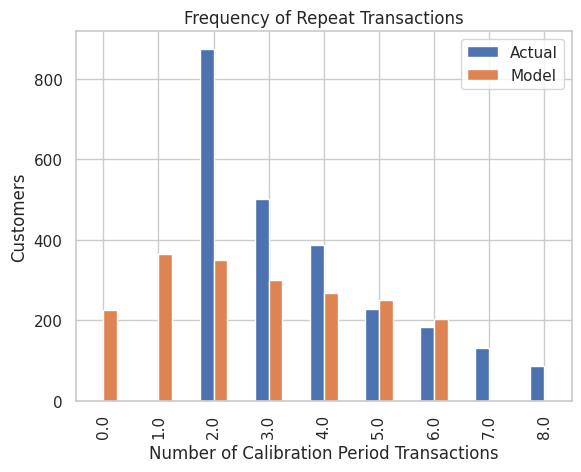

In [313]:
# Model Fitting 
plot_period_transactions(BGF)